In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, f1_score, 
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

X_train = pd.read_csv("model_data/clf_X_train.csv")
y_train = pd.read_csv("model_data/clf_y_train.csv").values.ravel()
X_test = pd.read_csv("model_data/clf_X_test.csv")
y_test = pd.read_csv("model_data/clf_y_test.csv").values.ravel()

print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Hit rate — Train: {y_train.mean():.3f} | Test: {y_test.mean():.3f}")

Train: (13580, 42) | Test: (2746, 42)
Hit rate — Train: 0.253 | Test: 0.239


In [3]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [5]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        class_weight="balanced",  # handles imbalance
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handles imbalance
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss",
        verbosity=0
    )
}

In [7]:
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"{'='*60}")
    
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
   
    auc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "auc_roc": auc,
        "avg_precision": ap,
        "f1": f1
    }
    
    print(f"\n  AUC-ROC: {auc:.4f} | Avg Precision: {ap:.4f} | F1: {f1:.4f}")
    print(f"\n{classification_report(y_test, y_pred, target_names=['Non-Hit', 'Hit'])}")


  Logistic Regression

  AUC-ROC: 0.8447 | Avg Precision: 0.5942 | F1: 0.5857

              precision    recall  f1-score   support

     Non-Hit       0.87      0.87      0.87      2089
         Hit       0.58      0.59      0.59       657

    accuracy                           0.80      2746
   macro avg       0.73      0.73      0.73      2746
weighted avg       0.80      0.80      0.80      2746


  Random Forest

  AUC-ROC: 0.8529 | Avg Precision: 0.6055 | F1: 0.6209

              precision    recall  f1-score   support

     Non-Hit       0.90      0.81      0.85      2089
         Hit       0.54      0.73      0.62       657

    accuracy                           0.79      2746
   macro avg       0.72      0.77      0.74      2746
weighted avg       0.82      0.79      0.80      2746


  XGBoost

  AUC-ROC: 0.8339 | Avg Precision: 0.5750 | F1: 0.5683

              precision    recall  f1-score   support

     Non-Hit       0.86      0.87      0.87      2089
         Hit   

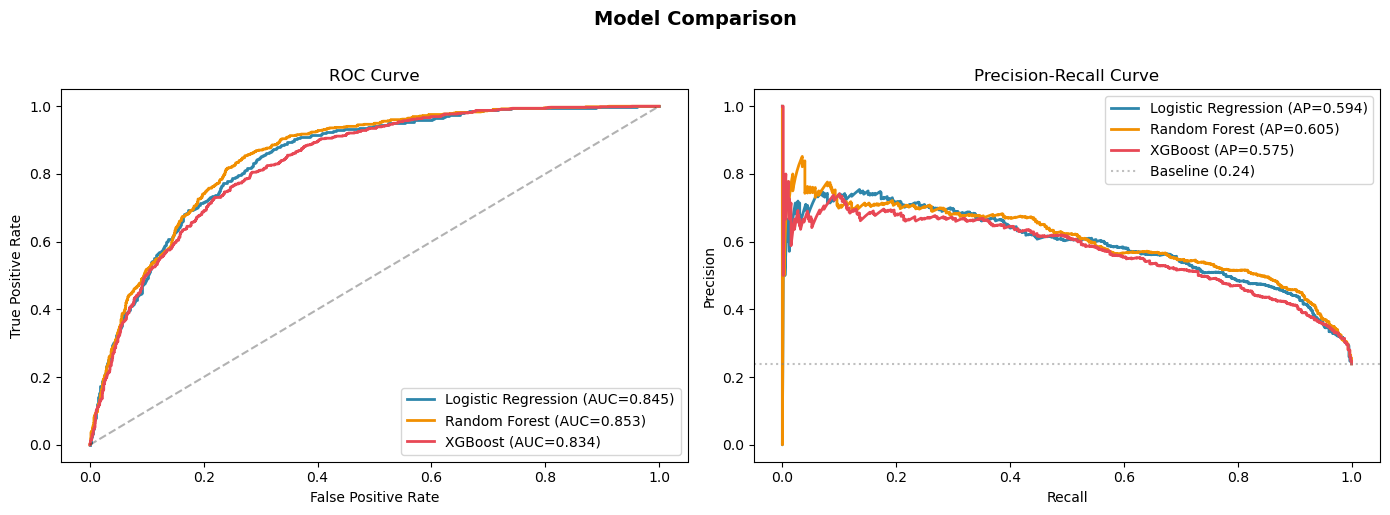

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {"Logistic Regression": "#2E86AB", "Random Forest": "#F18F01", "XGBoost": "#E84855"}

for name, res in results.items():
    c = colors[name]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    axes[0].plot(fpr, tpr, color=c, linewidth=2, 
                 label=f'{name} (AUC={res["auc_roc"]:.3f})')
    
    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_test, res["y_proba"])
    axes[1].plot(rec, prec, color=c, linewidth=2,
                 label=f'{name} (AP={res["avg_precision"]:.3f})')

axes[0].plot([0,1], [0,1], 'k--', alpha=0.3)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")

axes[1].axhline(y_test.mean(), color='gray', linestyle=':', alpha=0.5, label=f'Baseline ({y_test.mean():.2f})')
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend(loc="upper right")

fig.suptitle("Model Comparison", fontsize=14, fontweight="bold", y=1.02)
fig.tight_layout()
plt.show()

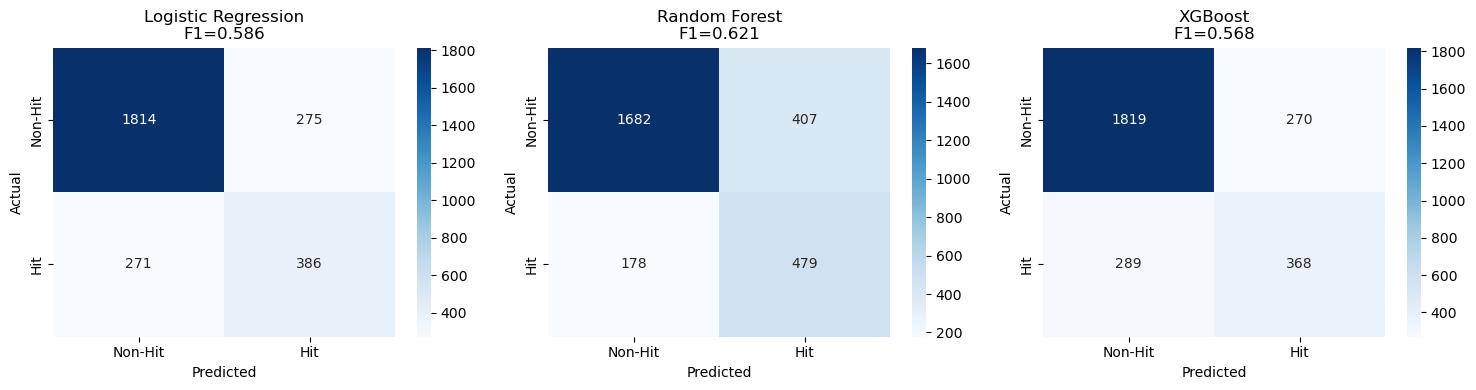

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res["y_pred"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=["Non-Hit", "Hit"], yticklabels=["Non-Hit", "Hit"])
    ax.set_title(f'{name}\nF1={res["f1"]:.3f}')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

fig.tight_layout()
plt.show()

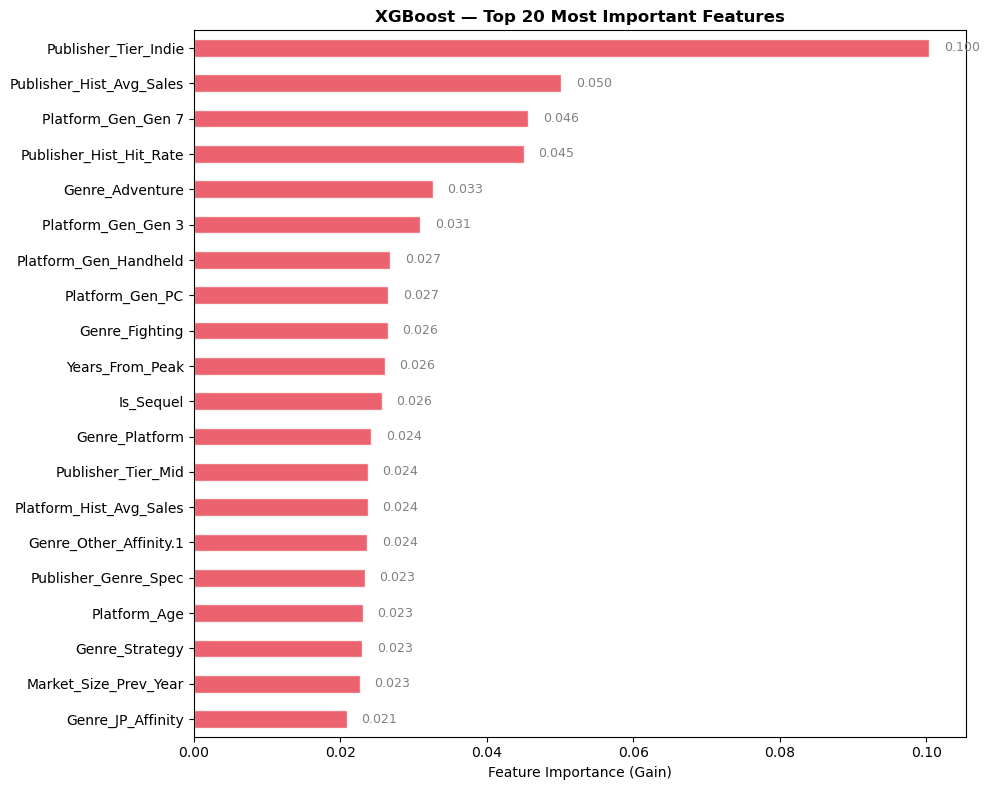

In [13]:
# XGBoost feature importance
xgb_model = results["XGBoost"]["model"]
importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top20 = importance.sort_values(ascending=True).tail(20)

fig, ax = plt.subplots(figsize=(10, 8))
top20.plot(kind="barh", color="#E84855", edgecolor="white", alpha=0.85, ax=ax)
ax.set_xlabel("Feature Importance (Gain)")
ax.set_title("XGBoost — Top 20 Most Important Features", fontweight="bold")

for i, (val, name) in enumerate(zip(top20.values, top20.index)):
    ax.text(val + 0.002, i, f"{val:.3f}", va="center", fontsize=9, color="gray")

fig.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400, 600],
    "subsample": [0.7, 0.8, 0.9],
}

xgb_tuned = XGBClassifier(
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    verbosity=0
)

grid_search = GridSearchCV(
    xgb_tuned, param_grid, cv=tscv,
    scoring="f1", n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print(f"\nBest params: {grid_search.best_params_}")
print(f"Best CV F1:  {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_proba_tuned = best_model.predict_proba(X_test)[:, 1]

print(f"\nTuned XGBoost — Test Results:")
print(f"  AUC-ROC: {roc_auc_score(y_test, y_proba_tuned):.4f}")
print(f"  F1:      {f1_score(y_test, y_pred_tuned):.4f}")
print(f"\n{classification_report(y_test, y_pred_tuned, target_names=['Non-Hit', 'Hit'])}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.7}
Best CV F1:  0.5198

Tuned XGBoost — Test Results:
  AUC-ROC: 0.8448
  F1:      0.6245

              precision    recall  f1-score   support

     Non-Hit       0.91      0.79      0.85      2089
         Hit       0.53      0.75      0.62       657

    accuracy                           0.78      2746
   macro avg       0.72      0.77      0.74      2746
weighted avg       0.82      0.78      0.79      2746



In [17]:
print("\n" + "="*65)
print("  PHASE 1 RESULTS SUMMARY")
print("="*65)
summary = pd.DataFrame({
    name: {"AUC-ROC": r["auc_roc"], "Avg Precision": r["avg_precision"], "F1": r["f1"]}
    for name, r in results.items()
}).T
summary.loc["XGBoost (Tuned)"] = {
    "AUC-ROC": roc_auc_score(y_test, y_proba_tuned),
    "Avg Precision": average_precision_score(y_test, y_proba_tuned),
    "F1": f1_score(y_test, y_pred_tuned)
}

print(summary.round(4).to_string())


  PHASE 1 RESULTS SUMMARY
                     AUC-ROC  Avg Precision      F1
Logistic Regression   0.8447         0.5942  0.5857
Random Forest         0.8529         0.6055  0.6209
XGBoost               0.8339         0.5750  0.5683
XGBoost (Tuned)       0.8448         0.5769  0.6245

✅ Phase 1 complete — proceed to Phase 2 (Clustering) when ready.
